# Proyecto 03 - Series de Tiempo


## 01 - Exploracion de datos

### Carga de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

In [ ]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [ ]:
data_2019.info()
data_2019.head()

In [ ]:
data_2018.info()
data_2018.head()

In [ ]:
data_2017.info()
data_2017.head()

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [ ]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

In [ ]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

In [ ]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

In [ ]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

#### Los datasets representan diferentes instacias en los años 2017, 2018 y 2019 de vehiculos que pasaron por peajes en la Ciudad de Buenos Aires.
#### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [ ]:
# Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
data = pd.concat([data_2019, data_2018, data_2017])
df = data

# Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(df.estacion=='Illia', df.forma_pago == 'EFECTIVO')
df = df[mask]

df.head()


In [ ]:
# Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')

# Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
df.drop(columns=['fecha','hora_fin'], inplace = True)

df.head()

In [ ]:
# Corregimos el nombre de fecha2 a fecha
df.rename(columns = {'fecha2':'fecha'}, inplace = True) 
df.head()

In [ ]:
# Reordenamos el dataset por fecha
df.sort_values('fecha', inplace = True)
df.reset_index(drop=True, inplace = True)
df

In [ ]:
# El tamaño del data frame es
print("Tamaño del data frame:", df.shape)

In [ ]:
# Calculo de los principales estadisticos
df.describe()

In [ ]:
# Total de NaN por columna
print("Total de NaN por columna: \n", df.isnull().sum())

In [ ]:
# Cantidad de instancias por dia de la semana
print("La cantidad de instancias por cada dia de la semana es:")
print(df['dia'].value_counts())

# Grafico
g = sns.countplot(data = df, x = "dia")

plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad')
plt.title('Cantidad de autos por dia de la semana')
plt.show()

**Comentario:** Como es esperado, podemos observar un descenso en la cantidad de vehiculos los sabados y domingos

In [ ]:
# Cantidad de instancias de cada sentido
print("La cantidad de instancias por cada sentido es:")
print(df['sentido'].value_counts())

# Grafico
g = sns.countplot(data = df, x = "sentido")

plt.xlabel('Sentido')
plt.ylabel('Cantidad')
plt.title('Cantidad de autos en cada sentido')
plt.show()

**Comentario:** Se observan mas ingresos a la ciudad que egresos de automobiles por este peaje

In [ ]:
# Cantidad de instancias de cada tipo de vehiculo
print("La cantidad de instancias por cada tipo de vehiculo es:")
print(df['tipo_vehiculo'].value_counts())

# Grafico
g = sns.countplot(data = df, x = "tipo_vehiculo")

plt.xlabel('Tipo de Vehiculo')
plt.ylabel('Cantidad')
plt.title('Cantidad de cada tipo de vehiculo')
plt.show()

**Comentario:** Es una ruta utilizada mayormente por un transito pesado

### Columnas que no aportan informacion
Quitamos las columnas que no aportan informacion ya sea por que otra la remplaza como "periodo" y "hora de inicio" por "fecha" y "forma_pago" y "estacion" puedne asumir un solo valor asi que no aportan informacion

In [ ]:
# Quitamos las columnas que no vamos a utilizar
df.drop(columns = ['periodo','hora_inicio','forma_pago','estacion'], inplace = True)

### Frecuencia diaria de vehiculos

In [ ]:
# Un domingo
hora = df.resample('H', on = 'fecha').sum()
aux = np.array(hora.iloc[:24])
y = aux.flatten()
x = np.linspace(1,24,24)

plt.figure(figsize = (15,6))
plt.bar(x,y)
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.title('Cantidad de vehiculos a cada hora un domingo')
plt.xticks(x)
plt.xlim(1, 24) 
plt.show()

**Comentario:** Se puede apreciar lo esperado en los horarios pico de un domingo, siendo estos el horario del almuerzo y a la noche cuando la gente retorna a la ciudad. 

In [ ]:
# Un lunes
aux = np.array(hora.loc["2017-01-02"])
y = aux.flatten()
x = np.linspace(1,24,24)

plt.figure(figsize = (15,6))
plt.bar(x,y)
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.title('Cantidad de vehiculos a cada hora un lunes')
plt.xticks(x)
plt.xlim(1, 24) 
plt.show()

**Comentario:** Se puede apreciar lo esperado. Se visualiza un maximo a las 10 de la mañana cuando la gente se dirige a trabajar y lo mismo a las 19:00 cuando la gente sale de trabajar

### Graficas temporales

In [ ]:
# Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(df.fecha, df.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [ ]:
# Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = df.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### Transformacion de datos

In [ ]:
diario = df.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

**Procederemos a  realizar:**
- Deteccion y eliminacion de outliers
- Imputacion de valores faltantes

#### Deteccion y eliminacion de outliers e imputacion de valores faltantes
Aplicamos el criterio del rango intercuartilico y usamos el bigote inferior como limite

In [ ]:
# Quitamos outliers

Q1 = diario.cantidad_pasos.quantile(0.25)
Q3 = diario.cantidad_pasos.quantile(0.75)
IQR = Q3-Q1 # Calculo del rango intercuartílico
l = Q1 - 1.5*IQR # Calculo del bigote inferior
print(l)

diario.cantidad_pasos[diario.cantidad_pasos < l] = np.nan
print(diario.isna().sum())


Remplazamos nuevamente los nulls generados por datos interpolados

In [ ]:
# Interpolamos los valores faltantes
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

### **Pregunta:** ¿Como es la tendencia de la cantidad de vehiculos ingresando a CABA por el paeaje de la autopista Arturo Illia?

In [ ]:
ventana = int(100)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana,min_periods=1, center = True).mean()
print(diario_promedio_tendencia)

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Vehiculos')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de Vehiculos - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Vehiculos')
plt.legend()
plt.show()

### Tendencia Lineal

In [ ]:
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)
diario.head()

In [ ]:
print(diario.isna().sum())

In [ ]:
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Vehiculos')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de Vehiculos - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de Vehiculos - Ajuste Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Vehiculos')
plt.legend()
plt.show()

**Conclusion:** Claramente podemos observar que existe una tendencia negativa por lo que en los últimos años ha disminuido la cantidad de vehículos transitando por dicho peaje pagando en efectivo

#### Sin filtar por medio de pago

In [ ]:
# Rehacemos el preprocesamiento con todos los medios de pago
del df
mask = data.estacion=='Illia'
df = data[mask]

pd.set_option('mode.chained_assignment', None)

df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')
df.drop(columns=['fecha','hora_fin'], inplace = True)
df.rename(columns = {'fecha2':'fecha'}, inplace = True) 
df.sort_values('fecha', inplace = True)
df.reset_index(drop=True, inplace = True)

df.drop(columns = ['periodo','hora_inicio','forma_pago','estacion'], inplace = True)

diario = df.resample('D', on = 'fecha').sum()

Q1 = diario.cantidad_pasos.quantile(0.25)
Q3 = diario.cantidad_pasos.quantile(0.75)
IQR = Q3-Q1
l = Q1 - 1.5*IQR
diario.cantidad_pasos[diario.cantidad_pasos < l] = np.nan
diario = diario.interpolate()

# Graficamos
ventana = int(100)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana,min_periods=1, center = True).mean()
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)

lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Vehiculos')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de Vehiculos - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de Vehiculos - Ajuste Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Vehiculos')
plt.legend()
plt.show()

In [ ]:
# Rehacemos el preprocesamiento con los pagos con telepase
del df
mask = np.logical_and(data.estacion=='Illia', data.forma_pago == 'TELEPASE')
df = data[mask]

pd.set_option('mode.chained_assignment', None)

df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')
df.drop(columns=['fecha','hora_fin'], inplace = True)
df.rename(columns = {'fecha2':'fecha'}, inplace = True) 
df.sort_values('fecha', inplace = True)
df.reset_index(drop=True, inplace = True)

df.drop(columns = ['periodo','hora_inicio','forma_pago','estacion'], inplace = True)

diario = df.resample('D', on = 'fecha').sum()

Q1 = diario.cantidad_pasos.quantile(0.25)
Q3 = diario.cantidad_pasos.quantile(0.75)
IQR = Q3-Q1
l = Q1 - 1.5*IQR
diario.cantidad_pasos[diario.cantidad_pasos < l] = np.nan
diario = diario.interpolate()

# Graficamos
ventana = int(100)
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana,min_periods=1, center = True).mean()
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)

lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Vehiculos')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de Vehiculos - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de Vehiculos - Ajuste Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Vehiculos')
plt.legend()
plt.show()

**Conclusion:** Habiendo observado la tendencia con todos los medios de pago y la de con telepase podemos concluir que la cantidad de autos que pasan por la estacion de peaje Ilia esta aumentando y que los conductores optan por la opcion de telepase

### Autocorrelacion

In [ ]:
nlags =  1000 # 52*20
autocorr = acf(diario.cantidad_pasos, nlags = nlags)
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diario.cantidad_pasos, lags = 100)
plt.show()

**Conclusion**: Se observa una no muy fuerte autocorrealacion en los datos con un maximos de 0.6

## 02 - Modelo de Machine Learning

In [ ]:
senial = diario.cantidad_pasos
senial.head()
senial.shape

In [ ]:
look_back = 100 # Cantidad de valores hacia atras

In [ ]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [ ]:
N_train = 10*52 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 4*52 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

In [ ]:
def evaluar_regresion_cv(model, X_train, y_train, k):
    
    cv = KFold(n_splits=k, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    rmse_test = np.sqrt(scores)

    print(f'Raíz del error cuadrático medio en Train: {np.round(rmse_test)}')
    
    print("%0.2f RMSE con una desviacion estandar de %0.2f" % (rmse_test.mean(), rmse_test.std()))

    return np.round(rmse_test.mean())

### Modelo 01: Random Forest Regressor (Benchmark)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [ ]:
evaluar_regresion_cv(rf, X_train, y_train, 5)

In [ ]:
# Optimizacion de hiperparametros con RandomizedSearch

# Numero de arboles en el arbol: es importante optimizar este hiperparametro ya que dictamina el tamañano y complejidad del modelo
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 250, num = 2)]

# Cantidad de instancias a considerar en cada division: probar con todas o con la raiz cuadrada del total para simplificar el modelo
#max_features = ['auto', 'sqrt']

# Cantidad maxima de niveles en cada arbol: Se debe optimizar para evitar un sub o sobre ajuste
#max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
#max_depth.append(None)

# Cantidad mininima necesaria de muestras para dividir un 
# nodo
#min_samples_split = [2, 10]

# Cantidad minima de muestras requerida para que sea un nodo: Cumple la funcion de "suavizar" el arbol en el caso de las regresiones. 
min_samples_leaf = [1, 2]

# Metodo para la seleccion de muestras para generar cada arbol: en el caso de True, se usan parte del ds para generar cada arbol y asi cada arbol es en si distinto del resto
#bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'min_samples_leaf': min_samples_leaf,}

CV_rf = RandomizedSearchCV(rf, random_grid, n_iter=100, random_state=0, cv=5)
CV_rf.fit(X_train, y_train)
rf_reg = CV_rf.best_estimator_

In [ ]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*52:
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [ ]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [ ]:
plt.figure(figsize=(30,8))

plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')

plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Vehiculos')
plt.show()

**Metrica a utlizar**
La mejor métrica para analizar nuestro modelo es la RMSE ya que es más sensibles a valores atípicos por lo que el efectos de grandes errores se ve reflejado. Además, al aplicar la raíz cuadrada solucionamos el problema de no ser el error de la misma magnitud ni unidades que la variable. Dado que se trata de un error, cuanto menor sea el valor obtenido mejor será la regresión.

In [ ]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

##### Comparacion con el modelo benchmark

In [ ]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [ ]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
RMSE_b=np.sqrt(MSE)
print(RMSE_b)

### Modelo 02: Prophet

In [ ]:
m = Prophet()

df_prophet = pd.DataFrame()
df_prophet['ds'] = diario.index
df_prophet['y'] = diario.cantidad_pasos.values
df_prophet.head()

In [ ]:
m.fit(df_prophet)

In [ ]:
# Cross Validation
df_cv = cross_validation(m,horizon = '100 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.describe()

In [ ]:
# Notar que le pedimos 10 años a futuro
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
# Optimizacion de hiperparametros
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m,horizon='100 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
m = Prophet(changepoint_prior_scale=0.1,seasonality_prior_scale=0.1)
m.fit(df_prophet)

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Calculo del RMSE
# Cross Validation
df_cv = cross_validation(m,horizon = '100 days')
df_p = performance_metrics(df_cv)
RMSE_m = df_p["rmse"].mean()

print(RMSE_m)

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

### Comparacion de modelos

In [ ]:
# Comparacion de RMSEs entre modelo benchmark y modelo final
vpt = round(((RMSE_b - RMSE_m)/RMSE_b)*100,2)

if vpt > 0:
    print("El error DISMINUYO en comparacion con el modelo benchmark un:",np.absolute(vpt),"%")
elif vpt < 0:
    print("El error AUMENTO en comparacion con el modelo benchmark un:",np.absolute(vpt),"%")
else:
    print("Ambos modelos tienen la misma performance.")

### Conclusiones
El potencial de la biblioteca prophet es muy grande y se obtiene un modelo muy poderoso de manera muy simple. Resulto mejor en un 32% que el modelo benchmark y con mucho menos trabajo de optimizacion de hiperparametros

El modelo ajusta una función a los datos de entrenamiento (probablemente del tipo sinusoidal) y a su vez tiene en cuenta la estacionalidad de estos datos, cosa que replica al realizar una predicción a futuro. A la hora de predecir, **el modelo utiliza** esta función ajustada que según el mes, día y hora realiza una predicción basándose en años anteriores y la ajusta según la tendencia de esos datos (creciente, decreciente o estacionaria)

## 03 - Investigacion

### Pregunta 1:
¿Como se podria mejorar los modelos regresores?

**Respuesta:** Se podrian mejorar incorporando mas atributos relevantes a los modelos de ML. Estos podiran ser por ejemplo el tipo de vehiculo, normalmente hay horarios cuando el transito pesado es mas comun, como temprano a la mañana para llevar meraderia a la ciudad. El dia se la semana aportaria informacion ya que esta fuertemetne correlacionado con el transito, los domingos o lunes el transito tiene un comportamiento muy distinto, lo mismo los viernes cuando la gente muchas veces se va de la ciuada por el fin de semana. 
Esto podria implementarse utilzando encoders.

### Pregunta 2:
¿El transito se comporta de igual manera en todos las estaciones de peaje?

**Respuesta:** Logicamente es esperable que haya horarios picos similares en todas estaciones de peaje similares pero no con la misma cantidad de vehiculos ingresando al mismo tiempo

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']


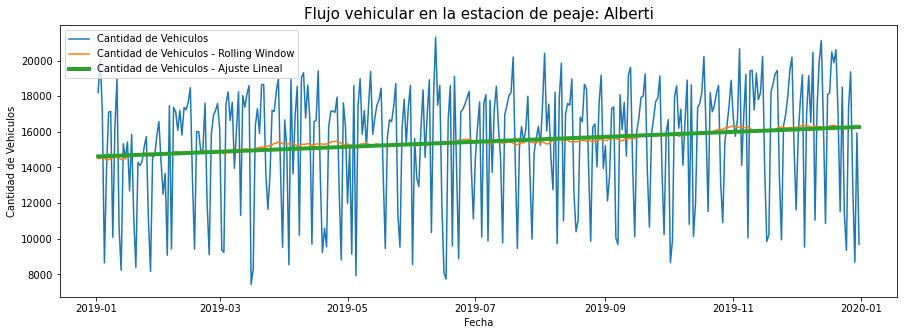

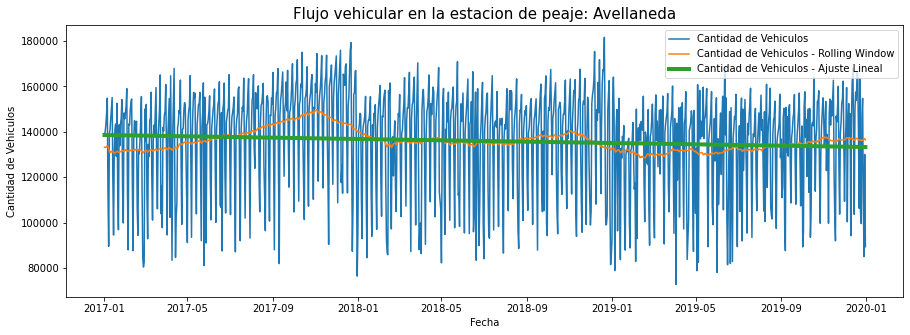

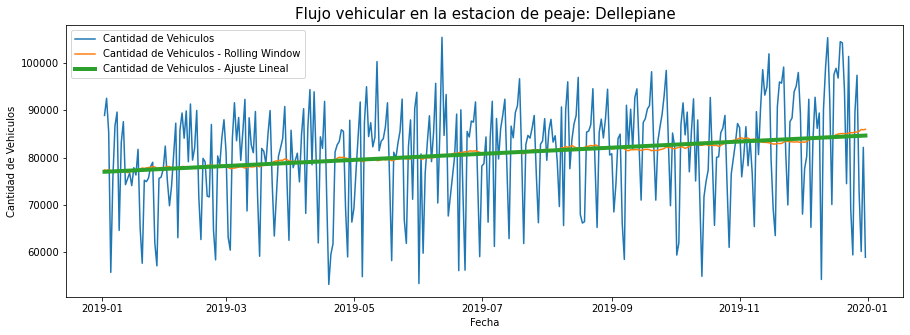

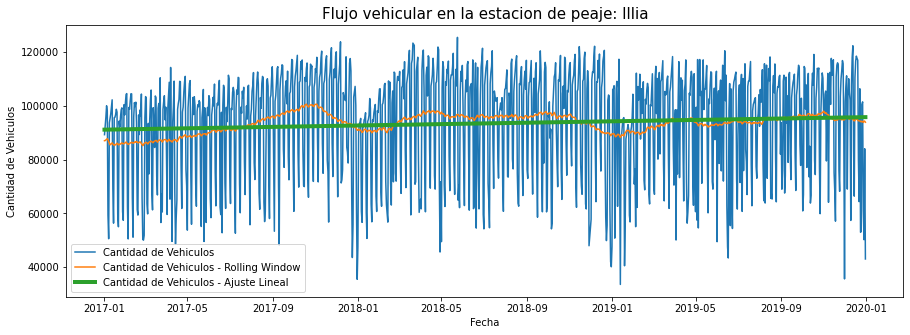

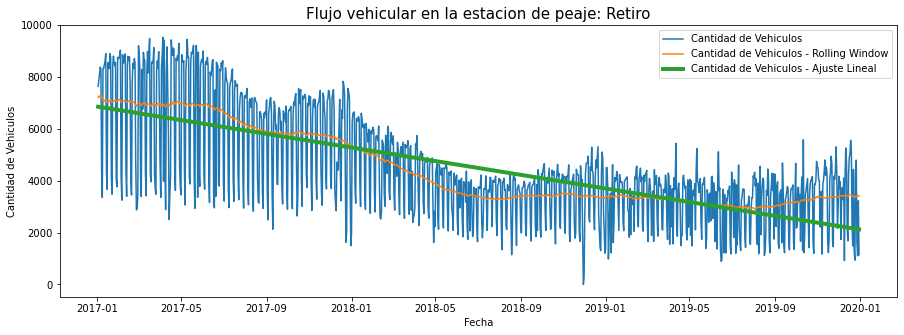

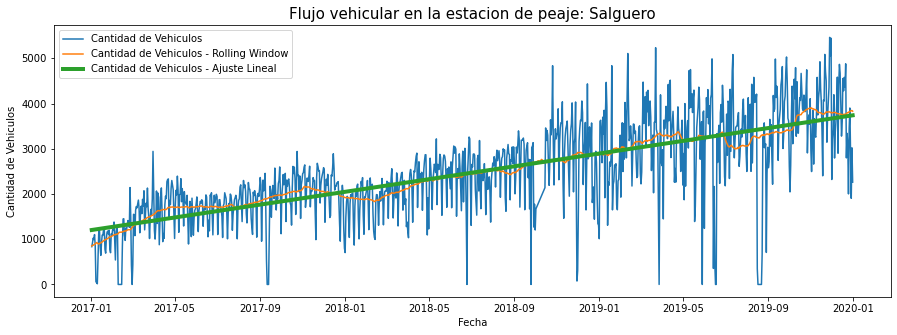

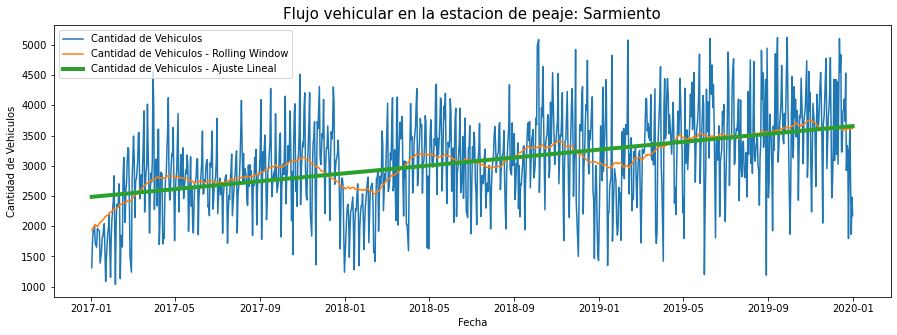

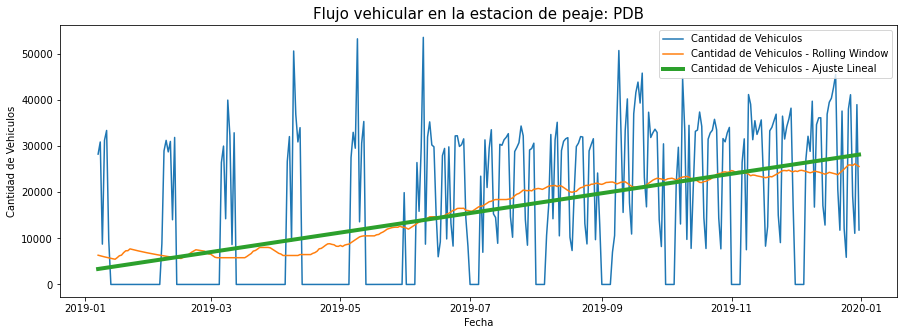

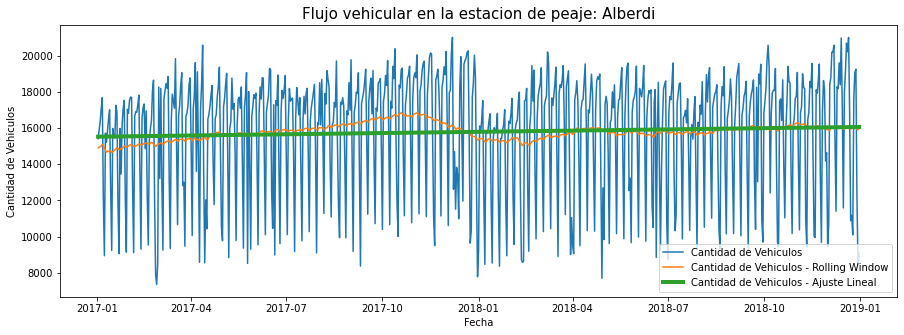

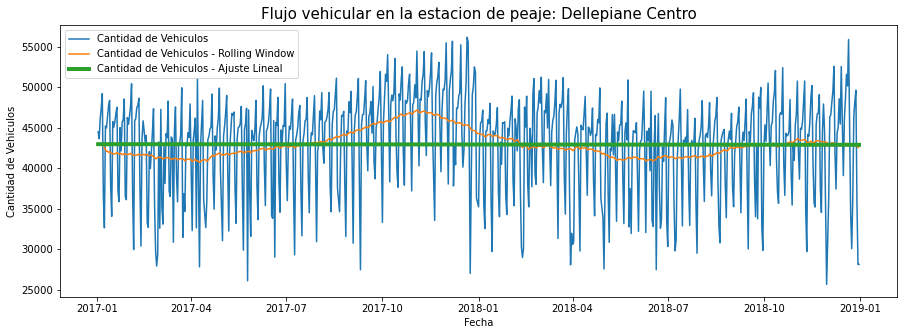

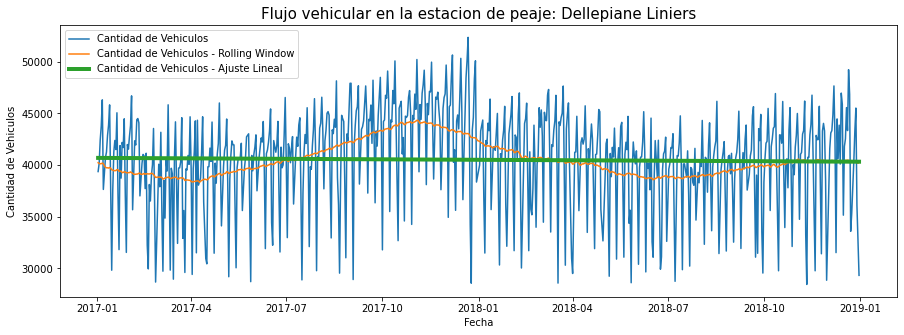

El maximo flujo de autos lo tiene Avellaneda y es 135969.0 en 3 años.


In [100]:
# Respuesta preliminar

print(data['estacion'].unique())
estaciones=data['estacion'].unique()
lista_transito_medio = []
lista_transito_medio_nombre = []

for estacion in estaciones:
    del df
    del diario
    mask = data.estacion==estacion
    df = data[mask]

    pd.set_option('mode.chained_assignment', None)

    df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')
    df.drop(columns=['fecha','hora_fin'], inplace = True)
    df.rename(columns = {'fecha2':'fecha'}, inplace = True) 
    df.sort_values('fecha', inplace = True)
    df.reset_index(drop=True, inplace = True)

    df.drop(columns = ['periodo','hora_inicio','forma_pago','estacion'], inplace = True)

    diario = df.resample('D', on = 'fecha').sum()

    Q1 = diario.cantidad_pasos.quantile(0.25)
    Q3 = diario.cantidad_pasos.quantile(0.75)
    IQR = Q3-Q1
    l1 = Q1 - 1.5*IQR
    l2 = Q3 + 1.5*IQR
    diario.cantidad_pasos[diario.cantidad_pasos < l1] = np.nan
    diario.cantidad_pasos[diario.cantidad_pasos > l2] = np.nan
    diario = diario.interpolate()
    diario.dropna()
    diario = diario.iloc[1: , :] # Dropeamos la primer instancia por un error en un dataset
    

    # Graficamos
    ventana = int(100)
    diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana,min_periods=1, center = True).mean()
    diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)

    lr = LinearRegression()
    lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

    plt.figure(figsize = (15,5))
    plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Vehiculos')
    plt.plot(diario_promedio_tendencia, label = 'Cantidad de Vehiculos - Rolling Window')
    plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de Vehiculos - Ajuste Lineal')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de Vehiculos')
    plt.title('Flujo vehicular en la estacion de peaje: {}'.format(estacion), fontsize =15)  
    plt.legend()
    plt.show()

    lista_transito_medio.append(diario["cantidad_pasos"].mean())
    lista_transito_medio_nombre.append(estacion)

max_value = max(lista_transito_medio)
max_index = lista_transito_medio.index(max_value)

print("El maximo flujo de autos lo tiene",lista_transito_medio_nombre[max_index],"y es",np.round(max(lista_transito_medio)),"en 3 años.")

**Conclusion:** Podemos observar que cada estacion de peaje es distinta. Las tendencias varian, la cantidad media de vehiculos e incluso los maximos y minimos. 

### Pregunta 3:
¿Como afecto el paseo del bajo en la cantidad de vehiculos por estacion de peaje?
[Wikipedia](https://es.wikipedia.org/wiki/Paseo_del_Bajo)

#### Flujo de trabajo
1. Comenzar encontrando la fecha exacta cuando se comenzó a utilizar el paseo del bajo.
1. Estimar con un mapa a que estaciones de peaje podría afectar este paseo del bajo.
1. Graficar las series de tiempo correspondientes a esas estaciones de peaje. 
1. Graficar un punto en la fecha de inauguración del paseo del bajo y ver si gráficamente se puede apreciar una variación en la tendencia.
1. Para realizar una verificación mas exacta:
    1. Separar el dataset en dos, desde la fecha inicial hasta la de inauguración del paseo del bajo y otra parte en adelante.
    1. Calcular la tendencia del primer dataset.
    1. Calcular la tendencia del segundo dataset.
    1. Ver cuanto varia uno con respecto al otro.
    1. Concluir
1. Concluir.
